# Future Network Constrained Linear Optimal Power Flow - with Floating Wind & Marine, and Emissions Modelling

## Overview

This notebook uses PyPSA-GB to model the GB power system by solving a network constrained Linear Optimal Power Flow (LOPF) problem.  In this notebook, floating wind, wave power, tidal stream and tidal lagoon are considered specifically.  After the optimisation, the greenhouse gas emissions of the period under consideration are calculated for the whole grid, and for each node.

Modifications have been made to the original release to separate out floating wind, wave power, tidal stream and tidal lagoon.  Specifically, 'generators.py' and 'renewables.py'.

'generators.py' arranges the generator mix for PyPSA.  To enable Floating Wind to be analysed separately, the offshore wind input files to 'generators.py' have been redefined.  There are now two: 'Sectoral Marine Plan 2020 - Fixed.csv' and 'Sectoral Marine Plan 2020 - Floating.csv'.  For the latter, in 'generators.py' the type is set to 'Floating Wind', while the carrier remains 'Wind Offshore'.  This modification is implemented at approximately line 157 in 'generators.py'.  Note that if the carrier is renamed to 'Floating Wind', 'renewables.py' fails as 'Floating Wind' is not a defined carrier.

'renewables.py' arranges the location and installed capacities of all renewable generation.  To enable wave power, tidal stream and tidal lagoon to be analysed separately, their type (and carrier) has been redefined in 'renewables.py'.  This modification is implemented in approximately line 577.

There is a fundamental difference currently between the marine generation and the floating wind: the floating wind relies on the 'atlite' module to compute the power generation time series, whereas the tidal stream and tidal lagoon are modelled and provided by a third party; and the wave power data is calculated manually offline, but covers 01/01/2010 to 31/12/2020.  The correct baseline year is selected automatically from the wave power data at around line 741 in 'renewables.py'.

The emissions calculation relies on emissions intensity factors for each type of generation - due to the signficant differences between certain types within a carrier.  This input data is provided from literature review.

## Setup

### Environments and Modules

In [1]:
import os
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())
src_path = os.environ.get('PROJECT_SRC')
os.chdir(src_path)

In [2]:
import pypsa
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import cartopy.crs as ccrs
import string
import numpy as np

import data_reader_writer
import generators

### Defining the Simulation Period

Set the required inputs for the LOPF: the start, end and year of simulation, and the timestep.

In [3]:
# write csv files for import
start = '2050-03-01 00:00:00'
end = '2050-03-01 23:30:00'
# year of simulation
year = int(start[0:4])
# time step as fraction of hour (default set to one hour to reduce computation)
time_step = 1.0

This notebook considers Floating Wind separately to fixed bottom offshore wind.

In [4]:
Floating_wind = True 
FW_merge_boolean = not(Floating_wind)

### Selecting the Future Energy Scenario

Choose from one of the National Grid Future Energy Scenarios.

In [5]:
# scenario = 'Consumer Transformation'
# scenario = 'Leading The Way'
# scenario = 'Steady Progression'
scenario = 'System Transformation'

Choose a baseline year (from 2010-2020). The baseline year determines which historical load profile and weather dataset is used for the future year modelled. The National Grid FES modellers used 2012 as their baseline year.

In [6]:
year_baseline = 2012

### Amending the Generator Types to include Floating Wind

'data_reader_writer.py' is an important script which reads in data from various sources and writes csv files in the format required for populating a PyPSA network object.  If merge_generators argument in 'data_reader_writer.data_writer' is set to 'True', the real power of generators with the same carrier, are summed at each node.

Alternatively, if merge_generators is set to 'False', each renewable (wind/solar/hydro) generator appears as a named site, greatly increasing the number of parameters in the optimisation.  The carriers affected are: Wind Offshore/Floating Wind, Wind Onshore, Solar. Large Hydro and Small Hydro.  Ideally, the change would only affect Floating Wind.  A workaround which replaces the carrier type is implemented in this notebook to include Floating Wind explicitly.

The difficulty with creating a new carrier, is that the model has been set up to consider only Offshore Wind and Onshore Wind.  The model itself computes the power time series for these carriers using the 'atlite' script.  This is unlike the power time series for Marine which is calculated 'offline', and so is trivial to create a new carrier for these Marine by amending 'renewables.py'.

The real power for every single generator (around 880) - stating bus, and other performance characteristics - is written by 'data_reader_writer.py' to 'generators.csv'.  Note that 'merge_generation_buses' is the key function, and this is located in 'generators.py' around line 1705.  This has been amended to include 'Floating Wind' as a carrier.

In [7]:
# Write nominal power for every single generator, stating bus, and other performance characteristics (no merging at this stage)

data_reader_writer.data_writer(start, end, time_step, year, year_baseline=year_baseline,
                               scenario=scenario, merge_generators=FW_merge_boolean)

c:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\core\arrays\datetimes.py:741: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(
c:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\core\indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value
C:\Users\alyden\OneDrive - University of Edinburgh\Python\PyPSA-GB v0.0.1\PyPSA-GB\interconnectors.py:201: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df_FES = df_FES[~df_FES.Variable.str.contains('(TWh)')]


In [8]:
# To rename sites as 'Floating Wind', create dataframe of generators.csv, ready to replace key cells
generators_FW = pd.read_csv(r"..\PyPSA-GB\LOPF_data\generators.csv", index_col=False)
generators_FW.loc[generators_FW['type'].eq('Floating Wind'), 'carrier'] = 'Floating Wind' # At index where column 'type' = Floating Wind, replace cell in column 'carrier', with 'Floating Wind'
generators_FW.to_csv(r"..\PyPSA-GB\LOPF_data\generators.csv", index = False)
generators.merge_generation_buses(year) # Merge_generators at each bus by calling function 'merge_generation_buses' from 'generators.py'

## Running the Optimisation

In [9]:
network = pypsa.Network()
network.import_from_csv_folder('LOPF_data')

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 19, 2], imported network file PyPSA version None.

INFO:pypsa.components:Applying weightings to all columns of `snapshot_weightings`
INFO:pypsa.io:Imported network LOPF_data has buses, generators, lines, links, loads, storage_units


Lines need to be scaled up to accommodate for future generation. An arbitrary value of 4 is selected.

In [10]:
contingency_factor = 4
network.lines.s_max_pu *= contingency_factor

In [11]:
network.lopf(network.snapshots, solver_name="gurobi", pyomo=False)

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.1s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Set parameter Username
Academic license - for non-commercial use only - expires 2022-09-03
Read LP format model from file C:\Users\alyden\AppData\Local\Temp\pypsa-problem-bwlu81_0.lp
Reading time = 0.30 seconds
obj: 106072 rows, 30385 columns, 185725 nonzeros
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 106072 rows, 30385 columns and 185725 nonzeros
Model fingerprint: 0x2ef71893
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  Objective range  [1e+00, 1e+09]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+09]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 102576 rows and 19215 columns
Presolve time: 0.11s
Presolved: 3496 rows, 11354 columns, 21399 nonzeros

Ordering time: 0.02s

Barrier statistics:
 AA' NZ     : 8.973e+03
 Factor NZ  : 1.101e+05 (roughly 7 MB of memory)
 Factor Ops : 7.906e+06 (less than

INFO:pypsa.linopf:Optimization successful. Objective value: 1.22e+13


('ok', 'optimal')

## Results

### Power by Generation Type

This section is akin to the original notebook, however real power output is interrogated by type exclusively - not carriers.  This is to make the code suitable for emissions modelling, and resilient to generation mixes with unabated fossil fuel (such as Coal, Diesel, Oil, CCGT and OCGT).

The total contribution to the grid wide generation is reported over the simulation period.  Nodal contributions are analysed in the emissions modelling section.

Note that there is a difference in terminology between generators and storage types; it is storage carriers that are plotted, however they are described as storage 'types'.

In [12]:
# define dataframe containing time series of real power generated, arranged by generation and storage types
p_by_type = network.generators_t.p.groupby(network.generators.type, axis=1).sum()

# Combining Hydro types into a single category and removing 
p_by_type['Hydro'] = (p_by_type['Small Hydro'] + p_by_type['Large Hydro'])

p_by_type.drop('Small Hydro', axis=1, inplace=True)
p_by_type.drop('Large Hydro', axis=1, inplace=True)

# Combining Diesel/Gas oil types into a single category and removing 
p_by_type['Diesel'] = (p_by_type['Diesel/Gas oil'] + p_by_type['Diesel/gas Diesel/Gas oil'])

p_by_type.drop('Diesel/Gas oil', axis=1, inplace=True)
p_by_type.drop('Diesel/gas Diesel/Gas oil', axis=1, inplace=True)

# Combining Nuclear types into a single category and removing 
p_by_type['Nuclear'] = (p_by_type['AGR'] + p_by_type['PWR'])

p_by_type.drop('AGR', axis=1, inplace=True)
p_by_type.drop('PWR', axis=1, inplace=True)

# Sorting generation types alphabetically
p_by_type = p_by_type[sorted(p_by_type.columns)]

# concatenating storage types
storage_by_type = network.storage_units_t.p.groupby(network.storage_units.carrier, axis=1).sum()
p_by_type = pd.concat([p_by_type, storage_by_type], axis=1)

# Including Interconnectors Import
imp = network.links_t.p0.copy()
imp[imp < 0] = 0
imp['Interconnectors Import'] = imp.sum(axis=1)
interconnector_import = imp[['Interconnectors Import']]
p_by_type = pd.concat([p_by_type, interconnector_import], axis=1)

# Including Interconnectors Export (note that post-processing occurs later in script)
exp = network.links_t.p0.copy()
exp[exp > 0] = 0
exp['Interconnectors Export'] = exp.sum(axis=1)
interconnector_export = exp[['Interconnectors Export']]

# Renaming Interconnector Import
p_by_type = p_by_type.rename(columns={'Interconnector': 'Interconnectors Import'})

In [13]:
# Removing columns where generation is zero
p_by_type = p_by_type.loc[:, p_by_type.any()]

In [14]:
# Setting all negative generation values to zero (work around, primarily batteries)
p_by_type[p_by_type < 0] = 0 # ideally stacked area chart would show all generation and charging

#saving to csv for post-processing
# p_by_type.to_csv('p_by_type.csv')

In [15]:
# Define colors for each generation/storage/interconnector type (note that Interconnector Export colour not defined in this way)

colors = {'Anaerobic Digestion': 'darkgoldenrod',
          'Biomass (co-firing)': 'yellowgreen',
          'Biomass (dedicated)': 'olivedrab',
          'CCGT': 'red',
          'CCS Biomass': 'darkolivegreen',
          'CCS Gas': 'lightcoral',
          'Diesel': 'lightgrey',
          'EfW Incineration': 'chocolate',
          'Floating Wind': 'royalblue',
          'Hydro': 'teal',
          'Hydrogen': 'paleturquoise',
          'Landfill Gas': 'olive',
          'Nuclear': 'lime',
          'OCGT': 'red',
          'Sewage Sludge Digestion': 'saddlebrown',
          'Solar Photovoltaics': 'yellow',
          'Tidal lagoon': 'mediumblue',
          'Tidal stream': 'midnightblue',
          'Unmet Load': 'black',
          'Wave power': 'steelblue',
          'Wind Offshore': 'cornflowerblue',
          'Wind Onshore': 'mediumseagreen',
          'Battery': 'mediumorchid',
          'Compressed Air': 'plum',
          'Liquid Air': 'thistle',
          'Pumped Storage Hydroelectric': 'deepskyblue',
          'Interconnectors Import': 'palevioletred'
         }

#           'Coal': 'dimgrey',
#           'Oil': 'red',
#           'Biomass': 'greenyellow',       
#           'Interconnectors Export': 'crimson',          
#           'Sour gas': 'darkred',
#           'Natural Gas': 'coral',
#           'Large Hydro': 'darkturquoise',
#           'Small Hydro': 'turquoise',

In [16]:
# create scenario file naming convention for saving outputs later
SC = ''.join(c for c in scenario if c.isupper())
s = SC + start + end + str(year_baseline)
for char in string.punctuation:
    s = s.replace(char,'')
    s = s.replace(" ",'')
filename = s + '.png'
print(filename)

ST20500301000000205003012330002012.png


c:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\plotting\_matplotlib\core.py:1391: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)


Text(0.5, 0, '')

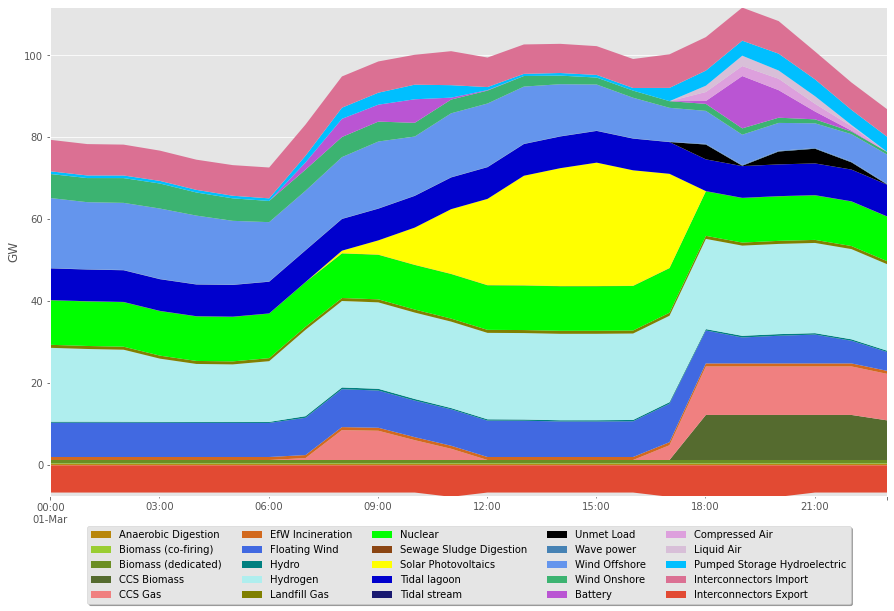

In [17]:
# Plot network-wide generation time series by generation type
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
(p_by_type / 1e3).plot(
    kind='area', ax=ax, linewidth=0,
    color=[colors[col] for col in p_by_type.columns])

# stacked area plot of negative values, prepend column names with '_' such that they don't appear in the legend
(interconnector_export / 1e3).plot.area(ax=ax, stacked=True, linewidth=0.)

# rescale the y axis
ax.set_ylim([(interconnector_export / 1e3).sum(axis=1).min(), (p_by_type / 1e3).sum(axis=1).max()])

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
ax.set_ylabel('GW')
ax.set_xlabel('')

### Emissions by Generation Type (including Interconnectors)

This section calculates a time series of emissions from each generation type according to the real power time series calculated in the previous section.  Note that these data include the emissions from interconnection, which is an important consideration - whether gross emissions from GB power sector include continental emissions.

In [18]:
p_by_type = p_by_type[sorted(p_by_type.columns)] # arrange p_by_type columns into alphabetical order to ensure consistency with EI factors
types = np.asarray(list(p_by_type.columns.values)) # create a numpy array from a list of generation types, from top row of generation mix dataframe
emissions_intensity = pd.read_csv('..\data\emissions_intensity_by_types.csv') # reading in the emissions intensity data contained in relevant .csv as a dataframe
emissions_intensity_LOPF = emissions_intensity[emissions_intensity['Type'].isin(types)] # create specific emissions intensity dataframe, removing the generation types that are not present in the generation mix
emissions_intensity_LOPF.sort_values('Type') # Sort specific emissions intensity dataframe alphabetically by Type to ensure consistency with generation mix dataframe
EI_factors = emissions_intensity_LOPF['Emissions Intensity [gCO2/kWh]'].to_numpy() # Create a numpy array of only the emissions intensity (EI) factors from the emissions intensity dataframe
E_by_type = p_by_type.multiply(time_step) # Create energy generation mix dataframe by multiplying power generation mix by the time step [MWh]
Emit_by_type = E_by_type.multiply(EI_factors, axis=1) # Create emissions dataframe. Multiply all columns in the energy dataframe by the numpy array of emissions intensity factors
Emit_by_type_te = Emit_by_type.div(1e3) # Convert gCO2/kWh * MWh to teCO2; the quotient of kWh:MWh (1e3) and gCO2:teCO2 (1e6) = 1e3
Emit_by_type_te = Emit_by_type_te.loc[:, Emit_by_type_te.any()] # Removing columns where emissions are zero
Emit_by_type_te

,Anaerobic Digestion,Biomass (co-firing),Biomass (dedicated),CCS Biomass,CCS Gas,EfW Incineration,Hydrogen,Interconnectors Import,Landfill Gas,Sewage Sludge Digestion
snapshot,,,,,,,,,,
2050-03-01 00:00:00,111.1914,19.65744,98.582062,0.000000,0.000000,220.174308,541.545970,1314.659341,220.44,15.06
2050-03-01 01:00:00,111.1914,19.65744,98.582062,0.000000,0.000000,220.174308,533.111840,1310.322342,220.44,15.06
2050-03-01 02:00:00,111.1914,19.65744,98.582062,0.000000,0.000000,220.174308,528.222275,1289.085064,220.44,15.06
2050-03-01 03:00:00,111.1914,19.65744,98.582062,0.000000,0.000000,220.174308,463.480258,1264.000418,220.44,15.06
2050-03-01 04:00:00,111.1914,19.65744,98.582062,0.000000,0.000000,220.174308,424.875942,1261.129521,220.44,15.06
2050-03-01 05:00:00,111.1914,19.65744,98.582062,0.000000,0.000000,220.174308,421.248887,1278.575311,220.44,15.06
2050-03-01 06:00:00,111.1914,19.65744,98.582062,0.000000,0.000000,220.174308,445.173020,1288.888373,220.44,15.06
2050-03-01 07:00:00,111.1914,19.65744,98.582062,0.000000,27.171900,220.174308,633.570630,1302.543197,220.44,15.06
2050-03-01 08:00:00,111.1914,19.65744,98.582062,0.000000,416.416317,220.174308,633.570630,1305.035400,220.44,15.06


Text(0.5, 0, '')

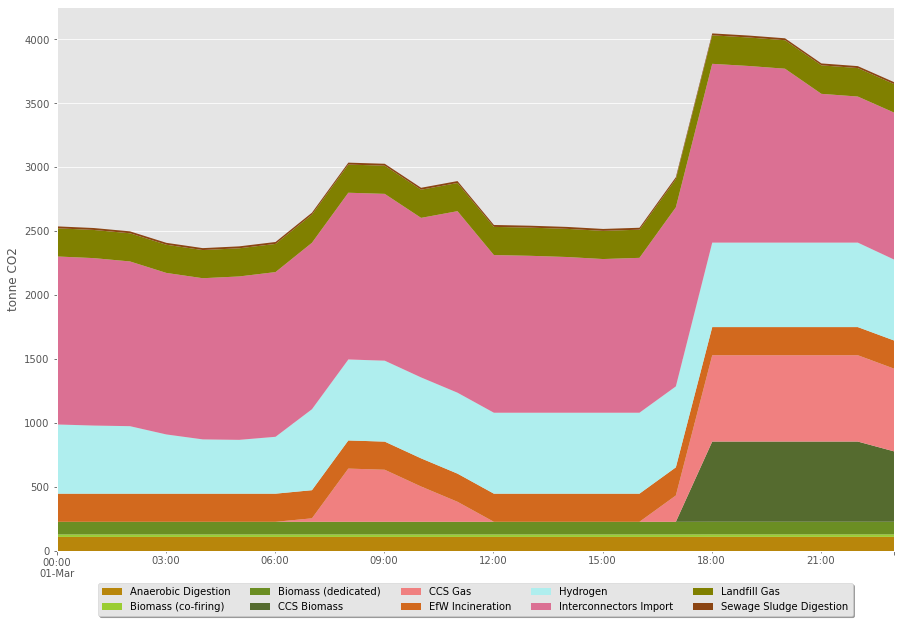

In [19]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
(Emit_by_type_te).plot(
    kind="area", ax=ax, linewidth=0,
    color=[colors[col] for col in Emit_by_type_te.columns])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

ax.set_ylabel("tonne CO2")
ax.set_xlabel("")

### Emissions Intensity (including Interconnectors)

A time series of the network-wide (including continental interconnectors) emissions intensity is determined below.  This is repeated later in the notebook excluding interconnectors.

In [20]:
# Time series of total emissions in tonnes (sum of emissions from all types - including interconnectors unless explicitly modified)
Total_Emit_t_te = Emit_by_type_te.sum(axis=1)

# Energy delivered to the grid at each time step
Total_E_t = E_by_type.sum(axis=1)

# The grid-wide emissions intensity in gCO2/kWh at each time step is given by:
EI_gCO2 = Total_Emit_t_te * 1e3 / Total_E_t
# EI_gCO2.to_csv('EI_gCO2.csv')

#### Average Emissions Intensity (including Interconnectors)

In [21]:
# Average emissions intensity over the period, method 1 = quotient of sums:
EI_avg_gCO2 = 1e3 * sum(Total_Emit_t_te) / sum(Total_E_t)
print("Average emissions intensity over the period, Method 1 = ", EI_avg_gCO2, "gCO2/kWh")

# Average emissions intensity over the period, method 2 = mean of dataframe:
print("Average emissions intensity over the period, Method 2 = ", EI_gCO2.mean(), "gCO2/kWh")

Average emissions intensity over the period, Method 1 =  31.717454935390275 gCO2/kWh
Average emissions intensity over the period, Method 2 =  31.798810621675802 gCO2/kWh


### Emissions by Node (excluding Interconnectors)

The emissions intensity arising at each node can be calculated by inspection of the generation mix at each node.

In [22]:
# The main data originates from a pypsa network object: real power time series from each generator before node aggregation
power_t_by_generator = network.generators_t.p
generators_by_bus = network.generators.bus # Create a list of generators and their <bus>, in the same sequence as above
generators_by_type = network.generators.type # Create a list of generators and their <types>, in the same sequence as above
power_t_by_generator.loc[len(power_t_by_generator)] = generators_by_bus # Append the bus of each generator to the end of the time series of real power generation
power_t_by_generator.loc[len(power_t_by_generator)] = generators_by_type # Append the type of each generator to the end of the time series of real power generation
power_t_by_generator.to_csv('power_t_by_generator.csv') # This will be the main dataframe used to interrogate the generation type mix at each node

# NB: This treatment can require the kernal to be restarted if run (and therefore executes appending) multiple times.

In [23]:
df = pd.read_csv('power_t_by_generator.csv')
loc_and_type = df.iloc[len(df.index) - 2:, :].T # create new df for generator information (bus/type) only
loc_and_type['sitename'] = loc_and_type.index.values # make this a column rather than just the index (need to merge on it later)
loc_and_type.columns= ['location', 'type', 'sitename']
loc_and_type = loc_and_type[1:] # remove row of headers

In [24]:
df.drop(labels=[(len(df)-2),(len(df)-1)], axis=0, inplace=True) # remove site (bus/type) information from power data
long_table = pd.melt(df, id_vars='snapshot', var_name='sitename', value_name='power')
long_table = long_table.merge(loc_and_type, on='sitename') # merge the 'type' and 'loc' back in
long_table['power'] = pd.to_numeric(long_table['power'])

In [25]:
grouped = long_table.groupby(by=['snapshot', 'location', 'type']).sum() # sum up by group
grouped = grouped.reset_index(level=0)
grouped = grouped.reset_index(level=0)
grouped = grouped.reset_index(level=0)
wide_table_0 = grouped.pivot(index='snapshot', columns=['location', 'type'])['power'] # create table with all values of real power generation, even zero power
# wide_table_0.to_csv('wide_table_0.csv')

In [26]:
# remove types (columns) where no real power is generated
wide_table = grouped.pivot(index='snapshot', columns=['location', 'type'])['power']
wide_table.drop(columns=wide_table.columns[wide_table.sum()==0], inplace=True)
# wide_table.to_csv('wide_table.csv')

Now a large dataframe is available which contains the time series of real power for each type of generation at each node.  The next step is to lookup and multiply the emissions intensity of each generation type with these time series to find the time series of emissions.  Finding the emissions intensity of the generation mix is done below.

In [27]:
# create a dataframe of emissions intensity data by reading in the emissions intensity data contained in relevant .csv
emissions_intensity = pd.read_csv('..\data\emissions_intensity_by_types.csv')
emissions_intensity.columns = ['Type', 'EI']

In [28]:
# get vector of all the types for the full dataset
df2 = wide_table.columns
types_full = df2.get_level_values(1)
types_full = pd.DataFrame(types_full.values)
types_full.columns =['Types']

In [29]:
# create long list of all emissions intensity ordered by the real power generation table
EI_full = types_full.replace(dict(zip(emissions_intensity.Type, emissions_intensity.EI)))
EI_full = EI_full.squeeze()

In [30]:
# Create energy generation mix dataframe by multiplying power generation mix by the time step [MWh]
E_by_type_node = wide_table.multiply(time_step)
E_by_type_node_0 = wide_table_0.multiply(time_step)

In [31]:
# All emissions, including types (and locations) with zero emissions
emis_0 = pd.DataFrame(E_by_type_node.values*EI_full.values, columns=E_by_type_node.columns, index=E_by_type.index)

In [32]:
# remove types (columns) with zero emissions
emis = emis_0
emis.drop(columns=emis.columns[emis.sum()==0], inplace=True)
emis_bus = emis.T

In [33]:
# sum emissions by type at each location
emis_bus = emis_bus.groupby(by=['location']).sum()
emis_bus = emis_bus.T

In [34]:
# Convert gCO2/kWh * MWh to teCO2; the quotient of kWh:MWh (1e3) and gCO2:teCO2 (1e6) = 1e3
emis_by_bus_te = emis_bus.div(1e3)
# emis_by_bus_te.to_csv('emis_by_bus_te.csv')

Text(0.5, 0, '')

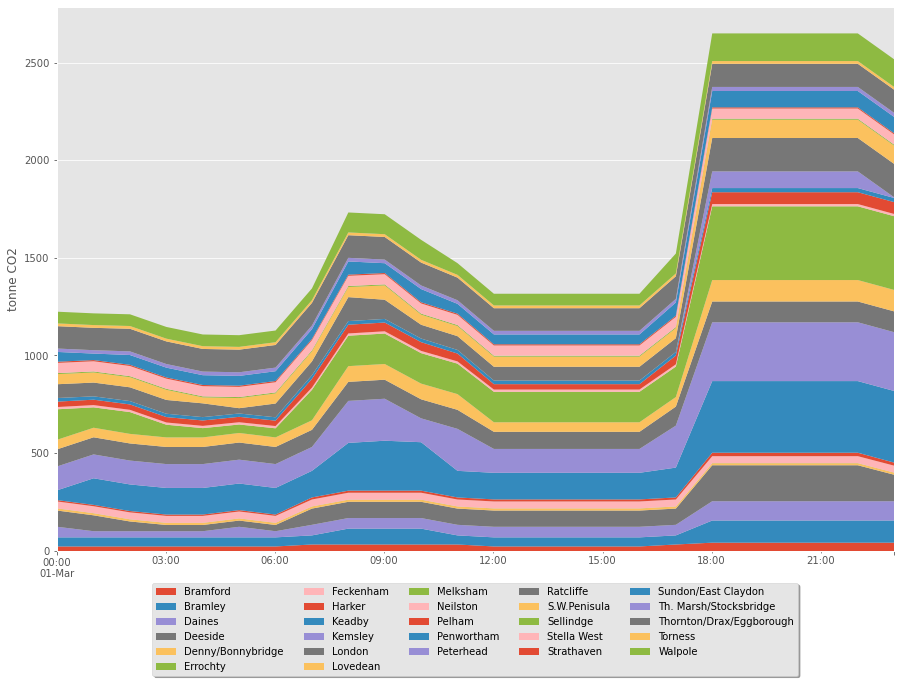

In [35]:
# plot how the emissions in tonnes changes at each node in time - NOW DOES NOT INCLUDE INTERCONNECTORS, HENCE DIFFERENT SHAPE
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
(emis_by_bus_te).plot(
    kind="area", ax=ax, linewidth=0)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

ax.set_ylabel("tonne CO2")
ax.set_xlabel("")

### Emissions Intensity (excluding Interconnectors)

In [36]:
# Total grid-wise emissions in tonnes of grid at each time step, excluding interconnectors
emis_te_ex_int = emis_by_bus_te.sum(axis=1)

# Grid-wise energy delivered at each time step
E_ex_int = E_by_type.drop(columns = 'Interconnectors Import')
E_ex_int = E_ex_int.sum(axis=1)

# casting new index to ensure compatibility for division
emis_te_ex_int.index = E_ex_int.index

# The grid-wide emissions intensity in gCO2/kWh at each time step is given by:
EI_gCO2_ex_int = emis_te_ex_int * 1e3 / E_ex_int
# EI_gCO2_ex_int.to_csv('EI_gCO2_ex_int.csv')

#### Average Emissions Intensity (excluding Interconnectors)

In [37]:
# Average emissions intensity over the period, method 1 = quotient of sums:
EI_gCO2_ex_int_avg = 1e3 * sum(emis_te_ex_int) / sum(E_ex_int)
print("Method 1 = ", EI_gCO2_ex_int_avg, "gCO2/kWh")

# Average emissions intensity over the period, method 2 = mean of dataframe:
print("Method 2 = ", EI_gCO2_ex_int.mean(), "gCO2/kWh")

Method 1 =  19.50792996323217 gCO2/kWh
Method 2 =  19.344281985243924 gCO2/kWh


#### Nodal Emissions Intensity (excluding Interconnectors)

The emissions intensity at each location can be considered per time step, or averaged over the period.  The variation in emissions intensity is plotted in time at each node.

In [38]:
# sum energy by type at each node [MWh]
E_by_node = E_by_type_node.T
E_by_node = E_by_node.groupby(by=['location']).sum()
E_by_node = E_by_node.T

In [39]:
# casting new index to ensure compatibility for division
E_by_node.index = emis_by_bus_te.index
# E_by_node.to_csv('E_by_node.csv')

In [40]:
# emissions intensity by node
EI_by_node = 1e3 * emis_by_bus_te  / E_by_node
EI_by_node.fillna(0, inplace=True) # set NaN to zero - created when emissions at a node don't appear because all nodal generation is zero emissions
EI_by_node['Average'] = EI_by_node.mean(axis=1) # create new column containing the average across all nodes
# EI_by_node.to_csv('EI_by_node.csv')

Text(0.5, 0, '')

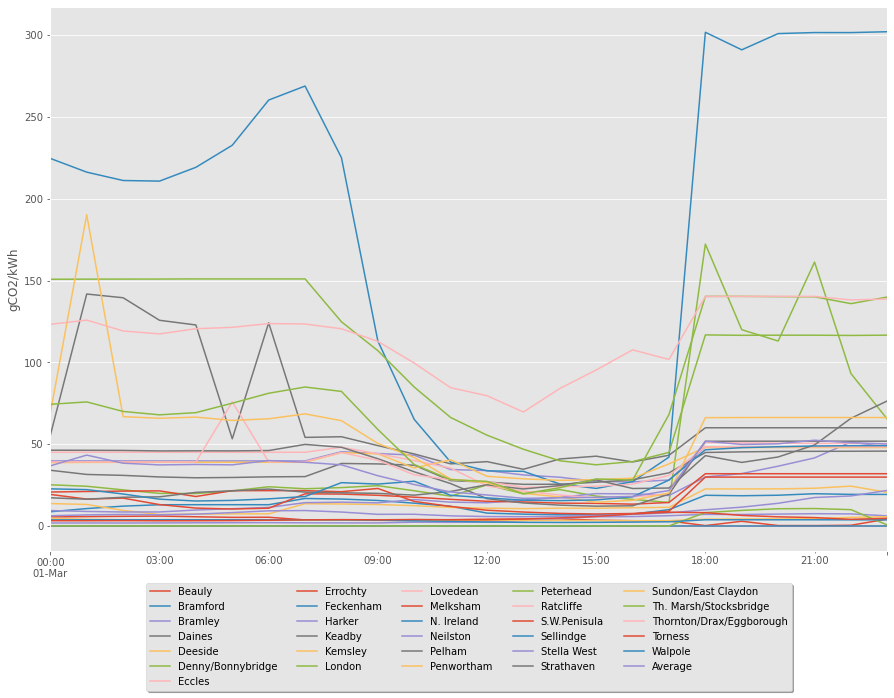

In [41]:
# plot how the emissions intensity in [gCO2/kWh] changes at each node in time (zero emissions intensity not shown)
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
EI_by_node.plot(ax = ax)

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
ax.set_ylabel("gCO2/kWh")
ax.set_xlabel("")

#### Average Nodal Emissions Intensity

The average emissions intensity over the period at each location can be plotted to consider local emissions.  The variation in emissions intensity is plotted in time at each node.

In [42]:
# defining a time stamp - note this is set up for the FINAL TIME STEP, not an average value
# Time stamp 'now' is not critical though as 'network' object is constant within each run and average defined elsewhere
now = network.snapshots[len(emis_by_bus_te)-1] 

# required order of buses for plotting on map is given by network object:
bus_order = network.buses_t.marginal_price.loc[now] # type = series.
bus_order = bus_order[:].index
frame = { 'location': bus_order }
bus_order_df = pd.DataFrame(frame)

In [43]:
# calculating gross emissions at all buses (including zero emission buses) in tonnes
emis_0_bus = emis_0.T
emis_0_bus = emis_0_bus.groupby(by=['location']).sum()
emis_0_bus = emis_0_bus.T
emis_0_by_bus_te = emis_0_bus.div(1e3) #; emis_0_by_bus_te

In [44]:
# sum energy by type at each node (including zero emission buses) in MWh
E_by_node_0 = E_by_type_node_0.T
E_by_node_0 = E_by_node_0.groupby(by=['location']).sum()
E_by_node_0 = E_by_node_0.T

In [45]:
# casting new index to ensure compatibility for division
E_by_node_0.index = emis_0_by_bus_te.index

In [46]:
# calculating average emissions intensity by node
EI_0_by_node = 1e3 * emis_0_by_bus_te  / E_by_node_0
EI_0_by_node.fillna(0) # set NaN to zero - created when emissions at a node don't appear because all nodal generation is zero emissions
EI_0_by_node['Average'] = EI_0_by_node.mean(axis=1) # create new column containing the average across all nodes

In [47]:
# average emissions intensity at each bus over the period (series)
EI_0_by_node_avg = EI_0_by_node.mean()
EI_0_by_node_avg = EI_0_by_node_avg.drop(labels = 'Average')
EI_0_by_node_avg = EI_0_by_node_avg.fillna(0)
EI_0_by_node_avg = EI_0_by_node_avg.to_frame().reset_index()
EI_0_by_node_avg.columns = ['location', 'EI_avg']; 

# define EI at interconnectors (exogeneous)
interconnectors = pd.DataFrame({'location': ['Netherlands',
                                             'Belgium',
                                             'France1',
                                             'France2',
                                             'Ireland',
                                             'Germany',
                                             'Ireland2',
                                             'Norway',
                                             'Denmark'],
                    'EI_avg': [10, 10, 10, 10, 10, 10, 10, 10, 10]}) # test figures to check location

#add new row to end of DataFrame
EI_0_by_node_avg = EI_0_by_node_avg.append(interconnectors, ignore_index = True)

df_merge = pd.merge(bus_order_df, EI_0_by_node_avg, on=['location'])

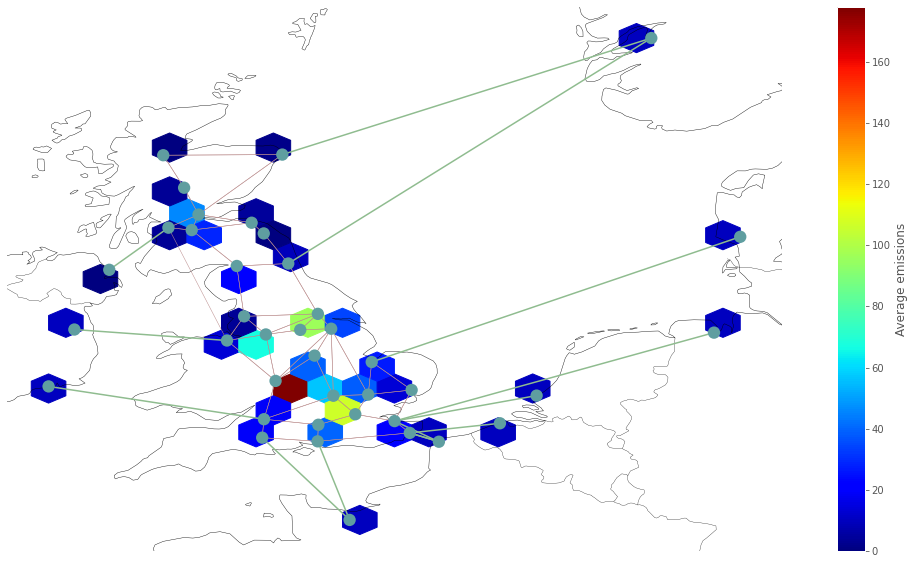

In [48]:
# creating figure
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})
fig.set_size_inches(20, 10)

network.plot(ax=ax, line_widths=pd.Series(0.5, network.lines.index))
plt.hexbin(network.buses.x, network.buses.y,
           gridsize=20,
           C=df_merge['EI_avg'],
           cmap=plt.cm.jet)

# for some reason the colorbar only works with graphs plt.plot
# and must be attached plt.colorbar

cb = plt.colorbar()
cb.set_label('Average emissions')

# Future Work

In [49]:
# Need to code in some figure / data saving automation
# Separate into positive and negative columns:
    # Battery (Gen), Battery (Charge)
    # Compressed Air (Gen), Compressed Air (Store)
    # Liquid Air (Gen), Liquid Air (Store)
    # Pumped Storage (Gen), Pumped Storage (Store) 
    # Tidal lagoon (Gen), Tidal lagoon (Pump)
    # Interconnector (Import), Interconnector (Export)
# Implement country emissions intensity per node, and change per year
# Find out power flows using line loading (draft below) and power angle

## Accounting for nodal emissions flows using line loading and power flows

Line loading stats and graph are shown below.  Further work required to translate this to nodal emissions flows.

In [50]:
# what is the direction of these flows?

print("With the linear load flow, there is the following per unit loading:")
loading = network.lines_t.p0.loc[now] / network.lines.s_nom
loading.describe()

With the linear load flow, there is the following per unit loading:


count    99.000000
mean      0.302563
std       0.695615
min      -0.403988
25%      -0.085461
50%       0.173719
75%       0.433847
max       4.000000
dtype: float64

(<matplotlib.collections.PatchCollection at 0x195ceaddc70>,
 <matplotlib.collections.LineCollection at 0x195ceae4df0>)

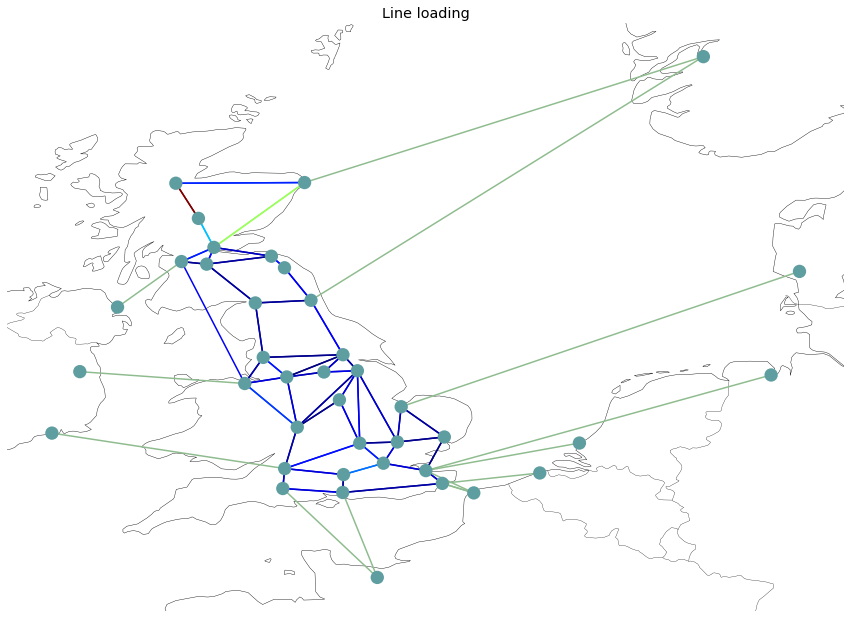

In [51]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})
fig.set_size_inches(15, 17)

network.plot(ax=ax, line_colors=abs(loading), line_cmap=plt.cm.jet, title="Line loading")